# Projeto de Aprendizado de Máquina: Classificador Musical

Marina Rocha Guimarães

Ygor Kupas

Temos dois objetivos centrais nesse notebook:

* No cenário I iremos utilizar um SVM e analisar os diferentes resultados obtidos ao utilizarmos diferentes extrações de features (LPC, MFCC e Mel Spectogram) e suas combinações (MFCC + LPC e Mel Spectogram + LPC). Isso é uma simplificação baseada no estudo realizado em [1];
    
* No cenário II iremos utilizar 3 SVMs, com o intuito de comparar os resultados obtidos no cenário I com o resultado obtido ao separar inicialmente os 4 estilos musicais em 2 grupos distintos (como feito em [2]).

[1] [Mutiara,A.B.; Refianti,R.; Mukarromah, N. R. A. Musical Genre Classification Using Support Vector Machines and Audio Features. Faculty of Computer Science and Information Technology, Gunadarma University. Setembro, 2016](https://pdfs.semanticscholar.org/92b4/66160755cd4c540cad6ab744019ee006e4ec.pdf)

[2] [XU, Changseng et al. Musical Genre Classification Using Support Vector Machines. Laboratories for Information Technology, 2003](https://www.researchgate.net/publication/4015150_Musical_genre_classification_using_support_vector_machines)


Indice<br/><br/>1 - [Importando Libs](#1---Importando-Libs)<br/>2 - [Apagando os avisos do notebook](#2---Apagando-os-avisos-do-notebook)<br/>3 - [Carregando Dataset](#3---Carregando-Dataset)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 - [Testando os audios](#3.1---Testando-os-audios)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 - [Separando Treinamento e Teste](#3.2---Separando-Treinamento-e-Teste)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2.1 - [Verificando a distribuição de treinamento e teste entre os estilos musicais](#3.2.1---Verificando-a-distribuição-de-treinamento-e-teste-entre-os-estilos-musicais)<br/>4 - [Extração de Features](#4---Extração-de-Features)<br/>5 - [Cenário I](#5---Cenário-I)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1 - [Analisando os melhores parâmetros para cada extração de feature](#5.1---Analisando-os-melhores-parâmetros-para-cada-extração-de-feature)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.1 - [MFCC](#5.1.1---MFCC)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.2 - [Mel Spectogram](#5.1.2---Mel-Spectogram)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.3 - [LPC](#5.1.3---LPC)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.4 - [MFCC + LPC](#5.1.4---MFCC-+-LPC)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.1.5 - [Mel Spectogram + LPC](#5.1.5---Mel-Spectogram-+-LPC)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.2 - [Analisando o melhor resultado para cada extração de feature](#5.2---Analisando-o-melhor-resultado-para-cada-extração-de-feature)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3 - [Melhor Resultado](#5.3---Melhor-Resultado)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5.3.1 - [Tentativa de predição com o melhor modelo](#5.3.1---Tentativa-de-predição-com-o-melhor-modelo)<br/>6 - [Cenário II](#6---Cenário-II)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.1 - [Analisando cada extração de feature](#6.1---Analisando-cada-extração-de-feature)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.2 - [Melhor Resultado](#6.2---Melhor-Resultado)<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;6.2.1 - [Tentativa de predição com o melhor modelo](#6.2.1---Tentativa-de-predição-com-o-melhor-modelo)<br/>7 - [Comparando os melhores resultados de cada cenário](#7---Comparando-os-melhores-resultados-de-cada-cenário)

# 1 - Importando Libs

In [1]:
# Libs matplotlib, numpy and pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lib librosa
import librosa
import librosa.display

# Lib OS
from os import listdir
from os.path import isfile, join, exists

# Lib ipwidgets
from ipywidgets import interact, IntSlider, interact_manual
import ipywidgets as widgets



# Lib IPtyhon
from IPython import display as ipd

# Lib glob
import glob

# Lib sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix

# Lib keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

# Lib collections
from collections import defaultdict

# 2 - Apagando os avisos do notebook

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 3 - Carregando Dataset

Baixar todo o [dataset](https://www.kaggle.com/carlthome/gtzan-genre-collection) (genre/) e colocar na mesma pasta do projeto.

In [3]:
def import_signal(path):
    
    # Test if path exists
    if( exists(path) == False ):
        print("Path does not exist, download from https://www.kaggle.com/carlthome/gtzan-genre-collection")
        return 0, 0
    
    # Load files woth glob
    files = glob.glob(path + '*.au')
    audios = []
    
    # Load audio files with sample rate 22050 Hz
    for file in files: 
        s, sr = librosa.core.load(file, sr=22050)
        audios.append(s)
        
    # Return audio vector and sample rate
    return audios, sr

Iremos considerar os seguintes rótulos para cada estilo:

    * Popular  =>  y=0 e y2=0
    * Clássico =>  y=1 e y2=0
    * Jazz     =>  y=2 e y2=1
    * Rock     =>  y=3 e y2=1
    
Isso porque y equivale ao rótulo do primeiro cenário, no qual temos apenas uma SVM e 4 possíveis saídas. Já y2 é usado no segundo cenário nas primeiras SVMs, as quais são utilizadas para separar os estilos popular e clássico dos estilos jazz e rock.

In [4]:
def get_audios_df():
    
    cont = 0
    audios_dict = defaultdict(list)
    for musical_genre in ['pop', 'classical', 'jazz', 'rock']:

        audios, sr =  import_signal(f'genres/{musical_genre}/')
        audios_dict[musical_genre].append(audios)
        
        audios_df_aux = pd.DataFrame([[x] for x in audios], columns=['x'])

        genre_dict_y = {'pop':0, 'classical':1, 'jazz':2, 'rock':3}
        genre_dict_y2 = {'pop':0, 'classical':0, 'jazz':1, 'rock':1}

        audios_df_aux['y'] = genre_dict_y[f'{musical_genre}']
        audios_df_aux['y2'] = genre_dict_y2[f'{musical_genre}']
        
        if cont == 0:
            audios_df = audios_df_aux
        else:
            audios_df = pd.concat([audios_df, audios_df_aux])
        cont+=1
        
    return audios_df, audios_dict, sr

In [5]:
audios_df, audios_dict, sr = get_audios_df()
audios_df = audios_df.sample(frac=1).reset_index(drop=True) # shuffle

print(f'Rows: {len(audios_df)}')
audios_df.head(2)

Rows: 400


x  y  y2
0  [-0.010284424, -0.018707275, -0.014312744, -0....  2   1
1  [-0.020233154, -0.051879883, -0.07672119, -0.0...  2   1

## 3.1 - Testando os audios

In [6]:
global chosed_musical_genre
chosed_musical_genre = 'pop'

global chosed_file
chosed_file = 0

In [7]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre
        chosed_musical_genre = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([15])'))

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [8]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file
        chosed_file = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([15])'))

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [9]:
ipd.Audio(audios_dict[chosed_musical_genre][0][chosed_file], rate=sr)

## 3.2 - Separando Treinamento e Teste

In [10]:
msk = np.random.rand(len(audios_df)) < 0.8
train = audios_df[msk]
test = audios_df[~msk]

print(f'Rows train:{len(train)}')
print(f'Rows test:{len(test)}')

Rows train:320
Rows test:80


### 3.2.1 - Verificando a distribuição de treinamento e teste entre os estilos musicais

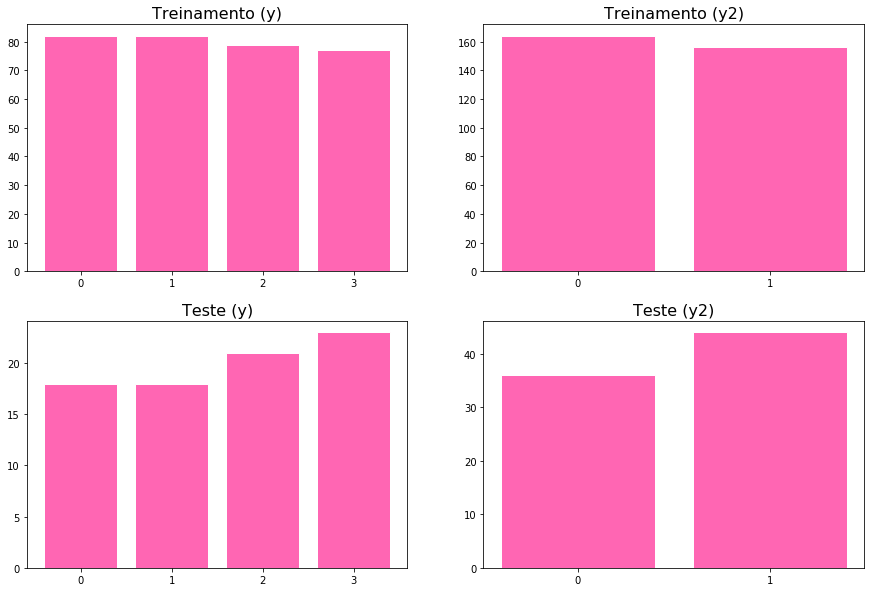

In [11]:
bins_y = np.sort(train['y'].unique())
bins_y2 = np.sort(train['y2'].unique())

fig, axs = plt.subplots(2, 2, figsize=(15,10))

axs[0, 0].bar(bins_y, np.histogram(train['y'], bins=len(bins_y))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[0, 0].set_xticks(bins_y)
axs[0, 0].set_title('Treinamento (y)', fontsize=16)

axs[0, 1].bar(bins_y2, np.histogram(train['y2'], bins=len(bins_y2))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[0, 1].set_xticks(bins_y2)
axs[0, 1].set_title('Treinamento (y2)', fontsize=16)

axs[1, 0].bar(bins_y, np.histogram(test['y'], bins=len(bins_y))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[1, 0].set_xticks(bins_y)
axs[1, 0].set_title('Teste (y)', fontsize=16)

axs[1, 1].bar(bins_y2, np.histogram(test['y2'], bins=len(bins_y2))[0], 
              align='center', color='#ff66b3', ec='#ffffff')
axs[1, 1].set_xticks(bins_y2)
axs[1, 1].set_title('Teste (y2)', fontsize=16)

plt.show()

# 4 - Extração de Features

In [12]:
def mfcc_feature_extract(x_column, sr):
    mfcc_list = []
    for x in x_column:
        mfcc_flatten = np.array(librosa.feature.mfcc(y=x, sr=sr)).flatten()
        zeros = np.zeros((26280 - len(mfcc_flatten))) # fazemos isso pois, para cada x temos diferentes
                                                      # tamanhos de mfcc - sendo o maximo=26280
        mfcc_list.append(np.concatenate((mfcc_flatten, zeros), axis=0))
    return mfcc_list

def mel_spect_feature_extract(x_column, sr):
    mel_spect_list = []
    for x in x_column:
        mel_spect_flatten = np.array(librosa.feature.melspectrogram(y=x, sr=sr)).flatten()
        zeros = np.zeros((168192 - len(mel_spect_flatten))) # fazemos isso pois, para cada x temos diferentes
                                                           # tamanhos de mel_spect - sendo o maximo=168192
        mel_spect_list.append(np.concatenate((mel_spect_flatten, zeros), axis=0))
    return mel_spect_list

def lpc_feature_extract(x_column, order=6):
    lpc_list = []
    for x in x_column:
        lpc = librosa.lpc(x, order=order)
        lpc_list.append(lpc)
    return lpc_list

In [13]:
def feature_extract(df, sr):
    
    # MFCC
    df['mfcc'] = mfcc_feature_extract(df['x'], sr)
    
    # LPC
    df['lpc'] = lpc_feature_extract(df['x'], order=6)
    
    # Mel Spectogram
    df['mel_spect'] = mel_spect_feature_extract(df['x'], sr)
    
    # MFCC + LPC
    df['mfcc_lpc'] = (
        df['mfcc'].apply(lambda x: x.tolist()) + 
        df['lpc'].apply(lambda x: x.tolist())
    )
    
    # Mel Spectogram + LPC
    df['mel_spect_lpc'] = (
        df['mel_spect'].apply(lambda x: x.tolist()) + 
        df['lpc'].apply(lambda x: x.tolist())
    )
    
    return df 

In [14]:
# Train
train = feature_extract(train, sr)
train.head(2)

x  y  y2  \
0  [-0.010284424, -0.018707275, -0.014312744, -0....  2   1   
1  [-0.020233154, -0.051879883, -0.07672119, -0.0...  2   1   

                                                mfcc  \
0  [-133.08755493164062, -141.53956604003906, -16...   
1  [-103.20085144042969, -115.94859313964844, -13...   

                                                 lpc  \
0  [1.0, -1.1317172, 0.40749294, 0.016367778, -0....   
1  [1.0, -3.0513067, 4.7828054, -4.916686, 3.4917...   

                                           mel_spect  \
0  [1.189058542251587, 1.0444172620773315, 0.7173...   
1  [1.1816438436508179, 0.7307288646697998, 0.568...   

                                            mfcc_lpc  \
0  [-133.08755493164062, -141.53956604003906, -16...   
1  [-103.20085144042969, -115.94859313964844, -13...   

                                       mel_spect_lpc  
0  [1.189058542251587, 1.0444172620773315, 0.7173...  
1  [1.1816438436508179, 0.7307288646697998, 0.568...

In [15]:
# Test
test = feature_extract(test, sr)
test.head(2)

x  y  y2  \
6   [0.02633667, 0.04815674, 0.05267334, 0.0505981...  1   0   
20  [0.05722046, 0.06097412, 0.06286621, 0.0684204...  0   0   

                                                 mfcc  \
6   [-197.08810424804688, -201.64662170410156, -20...   
20  [-283.2794189453125, -298.8136901855469, -313....   

                                                  lpc  \
6   [1.0, -2.9122496, 4.037222, -3.3088584, 1.5757...   
20  [1.0, -0.6768958, -0.041079897, -0.01663456, -...   

                                            mel_spect  \
6   [0.8257929086685181, 0.2656534016132355, 0.201...   
20  [90.31997680664062, 36.723472595214844, 17.299...   

                                             mfcc_lpc  \
6   [-197.08810424804688, -201.64662170410156, -20...   
20  [-283.2794189453125, -298.8136901855469, -313....   

                                        mel_spect_lpc  
6   [0.8257929086685181, 0.2656534016132355, 0.201...  
20  [90.31997680664062, 36.723472595214844, 17.299...

# 5 - Cenário I

* Usando uma rede SVM de apenas uma cama para reconhecer os 4 tipos musicais

In [16]:
def get_first_scenario_score_and_model(train, test, feature_ex='lpc', feature_ex2='mfcc_lpc', 
                                       two_features_ex=False, return_model=False, degree=3, 
                                       gamma=0.7, C=1.0):
    
    if two_features_ex:
        model = svm.SVC(kernel='poly', degree=degree, C=C)
        model.fit(train[f'{feature_ex2}'].to_list(), train['y'].to_list())

        train_score = (
            model.score(train[f'{feature_ex2}'].to_list(), train['y'].to_list())
        )

        test_score = (
            model.score(test[f'{feature_ex2}'].to_list(), test['y'].to_list())
        )
        
        if return_model: return model, train_score, test_score
        
        return train_score, test_score
        

    if feature_ex=='lpc':
        model = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    else:
        model = svm.SVC(kernel='poly', degree=degree, C=C)

    model.fit(train[f'{feature_ex}'].to_list(), train['y'].to_list())

    train_score = (
        model.score(train[f'{feature_ex}'].to_list(), train['y'].to_list())
    )

    test_score = (
        model.score(test[f'{feature_ex}'].to_list(), test['y'].to_list())
    )
    
    if return_model: return model, train_score, test_score
        
    return train_score, test_score

## 5.1 - Analisando os melhores parâmetros para cada extração de feature

### 5.1.1 - MFCC

In [17]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, 
                                                                 feature_ex='mfcc', 
                                                                 degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 79.4%
Test accuracy: 70.0%


Results with degree=2
Train accuracy: 81.2%
Test accuracy: 71.2%


Results with degree=3
Train accuracy: 77.5%
Test accuracy: 71.2%


Results with degree=4
Train accuracy: 71.6%
Test accuracy: 62.5%


Results with degree=5
Train accuracy: 68.4%
Test accuracy: 56.2%


Results with degree=6
Train accuracy: 68.1%
Test accuracy: 55.0%




Melhor resultado: degree=2

### 5.1.2 - Mel Spectogram

In [18]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, 
                                                                 feature_ex='mel_spect', 
                                                                 degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 60.3%
Test accuracy: 50.0%


Results with degree=2
Train accuracy: 48.8%
Test accuracy: 37.5%


Results with degree=3
Train accuracy: 47.8%
Test accuracy: 35.0%


Results with degree=4
Train accuracy: 46.9%
Test accuracy: 33.8%


Results with degree=5
Train accuracy: 46.6%
Test accuracy: 30.0%


Results with degree=6
Train accuracy: 46.6%
Test accuracy: 30.0%




Melhor resultado: degree=1

### 5.1.3 - LPC

In [19]:
for gamma in np.arange(0.5,2,0.1):
    print(f'Results with gamma={gamma}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, 
                                                                 feature_ex='lpc', 
                                                                 gamma=gamma)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with gamma=0.5
Train accuracy: 73.4%
Test accuracy: 57.5%


Results with gamma=0.6
Train accuracy: 75.0%
Test accuracy: 57.5%


Results with gamma=0.7
Train accuracy: 75.3%
Test accuracy: 58.8%


Results with gamma=0.7999999999999999
Train accuracy: 76.6%
Test accuracy: 58.8%


Results with gamma=0.8999999999999999
Train accuracy: 76.9%
Test accuracy: 58.8%


Results with gamma=0.9999999999999999
Train accuracy: 77.2%
Test accuracy: 58.8%


Results with gamma=1.0999999999999999
Train accuracy: 77.5%
Test accuracy: 58.8%


Results with gamma=1.1999999999999997
Train accuracy: 78.1%
Test accuracy: 58.8%


Results with gamma=1.2999999999999998
Train accuracy: 78.8%
Test accuracy: 57.5%


Results with gamma=1.4
Train accuracy: 78.8%
Test accuracy: 58.8%


Results with gamma=1.4999999999999998
Train accuracy: 79.1%
Test accuracy: 58.8%


Results with gamma=1.5999999999999996
Train accuracy: 79.7%
Test accuracy: 56.2%


Results with gamma=1.6999999999999997
Train accuracy: 79.7%
Test

Melhor resultado: gamma=1.5

### 5.1.4 - MFCC + LPC

In [20]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex2='mfcc_lpc', 
                                                                 two_features_ex=True, degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 79.4%
Test accuracy: 70.0%


Results with degree=2
Train accuracy: 81.2%
Test accuracy: 71.2%


Results with degree=3
Train accuracy: 77.5%
Test accuracy: 71.2%


Results with degree=4
Train accuracy: 71.6%
Test accuracy: 62.5%


Results with degree=5
Train accuracy: 68.4%
Test accuracy: 56.2%


Results with degree=6
Train accuracy: 68.1%
Test accuracy: 55.0%




Melhor resultado: degree=2

### 5.1.5 - Mel Spectogram + LPC

In [21]:
for degree in np.arange(1,7,1):
    print(f'Results with degree={degree}')
    
    train_score, test_score = get_first_scenario_score_and_model(train, test, feature_ex2='mel_spect_lpc', 
                                                                 two_features_ex=True, degree=degree)
    
    print('Train accuracy: {:.1%}'.format(train_score))
    print('Test accuracy: {:.1%}'.format(test_score))
    print('\n')

Results with degree=1
Train accuracy: 60.3%
Test accuracy: 50.0%


Results with degree=2
Train accuracy: 48.8%
Test accuracy: 37.5%


Results with degree=3
Train accuracy: 47.8%
Test accuracy: 35.0%


Results with degree=4
Train accuracy: 46.9%
Test accuracy: 33.8%


Results with degree=5
Train accuracy: 46.6%
Test accuracy: 30.0%


Results with degree=6
Train accuracy: 46.6%
Test accuracy: 30.0%




Melhor resultado: degree=1

## 5.2 - Analisando o melhor resultado para cada extração de feature

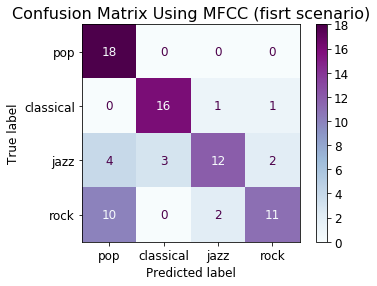

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 81.2%
Test accuracy:  71.2%




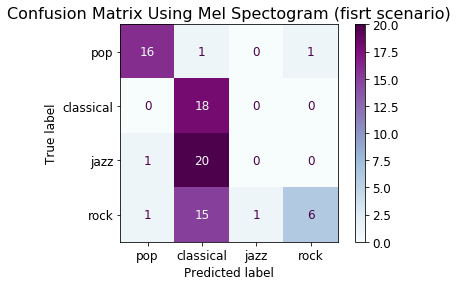

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 60.3%
Test accuracy:  50.0%




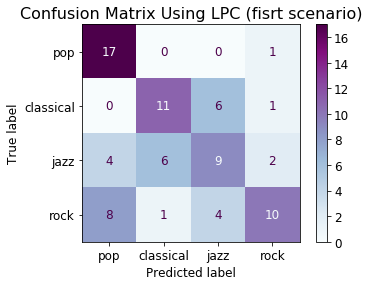

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 79.1%
Test accuracy:  58.8%




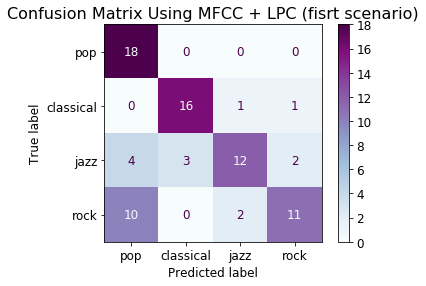

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 81.2%
Test accuracy:  71.2%




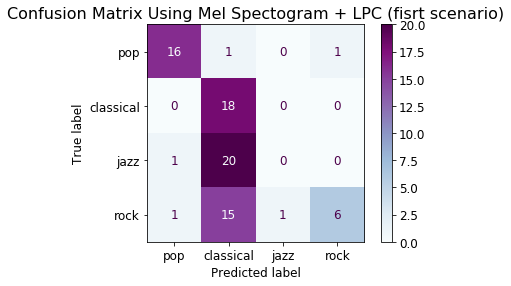

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 60.3%
Test accuracy:  50.0%




In [22]:
options = [('Confusion Matrix Using MFCC (fisrt scenario)', 'mfcc', None, False, 2, 0),
           ('Confusion Matrix Using Mel Spectogram (fisrt scenario)', 'mel_spect', None, False, 1, 0),
           ('Confusion Matrix Using LPC (fisrt scenario)', 'lpc', None, False, 0, 1.5),
           ('Confusion Matrix Using MFCC + LPC (fisrt scenario)', None, 'mfcc_lpc', True, 2, 0),
           ('Confusion Matrix Using Mel Spectogram + LPC (fisrt scenario)', None, 'mel_spect_lpc', True, 1, 0)]

for title, feature_ex, feature_ex2, two_features, degree, gamma in options:     
    
    model, train_score, test_score = (
        get_first_scenario_score_and_model(train, test, feature_ex=feature_ex, feature_ex2=feature_ex2, 
                                           two_features_ex=two_features, return_model=True, 
                                           degree=degree, gamma=gamma)
    )
       
    feature = feature_ex or feature_ex2
    
    plt.rcParams.update({'font.size': 12})
    disp = plot_confusion_matrix(model, test[f'{feature}'].to_list(), 
                                 test['y'].to_list(), labels=[0,1,2,3],
                                 display_labels=['pop', 'classical', 'jazz', 'rock'],
                                 cmap=plt.cm.BuPu)
    disp.ax_.set_title(title, fontsize=16)
    plt.figure(figsize=(20,20))
    plt.show()

    print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
    print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
    print('\n')

## 5.3 - Melhor Resultado

Analisando o melhor resultado com base principalmente na porcentagem de acerto no dataset de teste, temos 2 melhores modelos:
    * SVM com kernel=poly e extração de feature MFCC
    * SVM com kernel=poly e extração de feature MFCC+LPC

Nota-se que os dois resultados acima são identicos. Vamos então escolher o primeiro citado para verificar o resultado final.

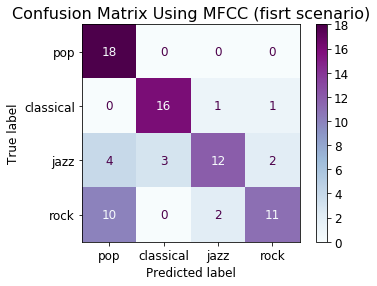

<Figure size 1440x1440 with 0 Axes>



Train accuracy: 81.2%
Test accuracy:  71.2%




In [424]:
model, train_score, test_score = (
    get_first_scenario_score_and_model(train, test, feature_ex='mfcc', 
                                       return_model=True, degree=2)
)

plt.rcParams.update({'font.size': 12})
disp = plot_confusion_matrix(model, test['mfcc'].to_list(), 
                             test['y'].to_list(), labels=[0,1,2,3],
                             display_labels=['pop', 'classical', 'jazz', 'rock'],
                             cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC (fisrt scenario)', fontsize=16)
plt.figure(figsize=(20,20))
plt.show()

print('\n')
print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
print('\n')

### 5.3.1 - Tentativa de predição com o melhor modelo

In [24]:
global chosed_musical_genre_scenario1
chosed_musical_genre_scenario1 = 'pop'

global chosed_file_scenario1
chosed_file_scenario1 = 0

In [25]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre_scenario1
        chosed_musical_genre_scenario1 = change['new']
        
w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [303]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file_scenario1
        chosed_file_scenario1 = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([53])'))
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([54])'))
w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [421]:
ipd.Audio(audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1], rate=sr)

In [423]:
audio_test = audios_dict[chosed_musical_genre_scenario1][0][chosed_file_scenario1]
audio_test_mfcc = mfcc_feature_extract([audio_test], sr)[0]

genre_dict = {0: 'popular', 1:'classico',
              2:'jazz', 3:'rock'}

predicted_musical_genre = genre_dict[model.predict([audio_test_mfcc])[0]]

print('\nA música inserida pertence ao estilo musical ' + '\033[1m' + f'{predicted_musical_genre}' + '\033[0;0m')


A música inserida pertence ao estilo musical rock


# 6 - Cenário II

* Usando 3 redes SVM:
    * SVM1 - separa os estilos pop e classico dos estilos jazz e rock
    * SVM2 - separa o estilo pop do estilo classico
    * SVM3 - separa o estilo jazz do estilo rock

In [29]:
def training_a_model(x, y, feature_ex, gamma, degree, C):
    if feature_ex=='lpc':
        model = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    else:
        model = svm.SVC(kernel='poly', degree=degree, C=C)
        
    model.fit(x, y)
    return model

In [30]:
def get_second_scenario_score_and_models(train, test, feature_ex_svm1='lpc', feature_ex_svm23='mfcc',
                                        degree=2, gamma=1.5, C=1.0, return_models=False):
    
    # SVM1
    model1 = training_a_model(train[f'{feature_ex_svm1}'].to_list(), 
                              train['y2'].to_list(),
                              feature_ex_svm1, gamma, degree, C)
    train['y2_predicted'] = model1.predict(train[f'{feature_ex_svm1}'].to_list())
    
    #SVM2
    train_0 = train[train['y2_predicted']==0]
    train_0 = train_0[train_0['y'].isin([0,1])]
    
    model2 = training_a_model(train_0[f'{feature_ex_svm23}'].to_list(), 
                              train_0['y'].to_list(),
                              feature_ex_svm23, gamma, degree, C)
    train_0['y_predicted'] = model2.predict(train_0[f'{feature_ex_svm23}'].to_list())
    test_0 = test[test['y2']==0]
    
    #SVM3
    train_1 = train[train['y2_predicted']==1]
    train_1 = train_1[train_1['y'].isin([2,3])]
    
    model3 = training_a_model(train_1[f'{feature_ex_svm23}'].to_list(), 
                              train_1['y'].to_list(),
                              feature_ex_svm23, gamma, degree, C)
    train_1['y_predicted'] = model3.predict(train_1[f'{feature_ex_svm23}'].to_list())
    test_1 = test[test['y2']==1]
    
    train_score = (
        model2.score(train_0[f'{feature_ex_svm23}'].to_list(), train_0['y'].to_list()) * 0.5 +
        model3.score(train_1[f'{feature_ex_svm23}'].to_list(), train_1['y'].to_list()) * 0.5
    )
    
    test_score = (
        model2.score(test_0[f'{feature_ex_svm23}'].to_list(), test_0['y'].to_list()) * 0.5 +
        model3.score(test_1[f'{feature_ex_svm23}'].to_list(), test_1['y'].to_list()) * 0.5
    )
    
    return model1, model2, model3, train_score, test_score

In [31]:
def second_scenario_predict_an_audio(feature1, feature2, model1, model2, model3):    
    y2_predicted = model1.predict(feature1)
    
    y_predicted_list = []
    i=0
    for predicted in y2_predicted:
        
        feature = feature2[i]
        
        if predicted == 0:
            y_predicted = model2.predict([feature])
        elif predicted == 1:
            y_predicted = model3.predict([feature])
            
        y_predicted_list.append(y_predicted)
        
        i+=1
    
    return y_predicted_list

## 6.1 - Analisando cada extração de feature

Aqui vamos analisar os resultados do cenário II alterando a extração de feature utilizada na SVM1 e nas SVM2 e SVM3 - vale ressaltar que a extração de feature utilizada na SVM2 é igual àquela utilizada na SVM3.

Por simplificação, vamos apenas analisar as extrações LPC e MFCC.

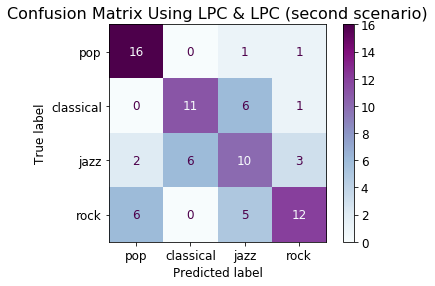

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 92.3%
Test accuracy:  82.7%




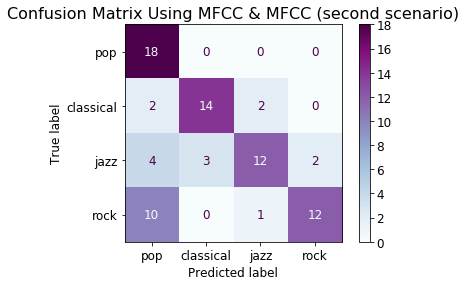

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 93.6%
Test accuracy:  89.3%




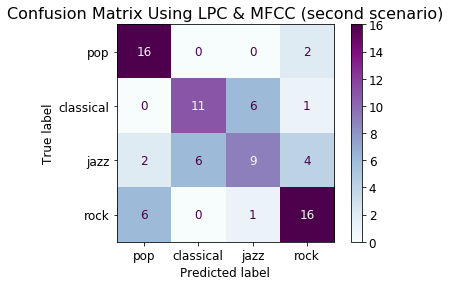

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 92.4%
Test accuracy:  89.3%




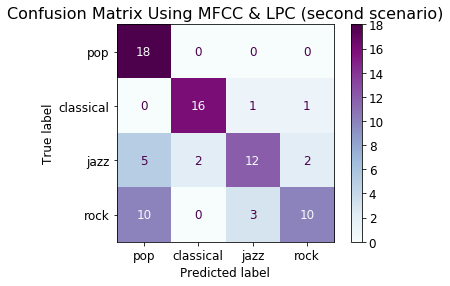

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 95.0%
Test accuracy:  88.6%




In [32]:
options = [('Confusion Matrix Using LPC & LPC (second scenario)', 'lpc', 'lpc', 0, 1.5),
           ('Confusion Matrix Using MFCC & MFCC (second scenario)', 'mfcc', 'mfcc', 2, 0),
           ('Confusion Matrix Using LPC & MFCC (second scenario)', 'lpc', 'mfcc', 2, 1.5),
           ('Confusion Matrix Using MFCC & LPC (second scenario)', 'mfcc', 'lpc', 2, 1.5),]

for title, feature_ex_svm1, feature_ex_svm23, degree, gamma in options:     
    
    model1, model2, model3, train_score, test_score = (
        get_second_scenario_score_and_models(train, test, feature_ex_svm1=feature_ex_svm1,
                                             feature_ex_svm23=feature_ex_svm23, degree=degree,
                                             gamma=gamma)
    )
    
    predictions = (
        second_scenario_predict_an_audio(test[f'{feature_ex_svm1}'].to_list(), 
                                         test[f'{feature_ex_svm23}'].to_list(), 
                                         model1, model2, model3)
    )
    predictions = [x[0] for x in predictions]
    
    plt.rcParams.update({'font.size': 12})
    
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test['y'].to_list(), predictions),
                                  display_labels=['pop', 'classical', 'jazz', 'rock'])
    disp = disp.plot(include_values=True,
                     cmap=plt.cm.BuPu)
    disp.ax_.set_title(title, fontsize=16)
    
    plt.figure(figsize=(20,20))
    plt.show()

    print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
    print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
    print('\n')

## 6.2 - Melhor Resultado

Analisando o melhor resultado com base principalemente na porcentagem de acerto no dataset de teste, o melhor modelo foi o que utilizou kernel=poly e extração de feature MFCC nos 3 SVM utilizados.

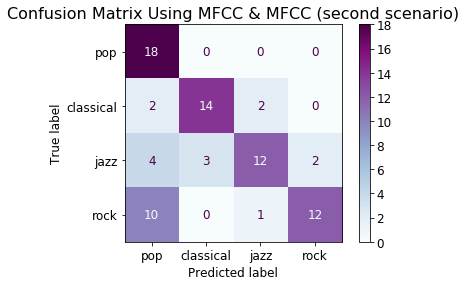

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 93.6%
Test accuracy:  89.3%




In [425]:
model1, model2, model3, train_score, test_score = (
    get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc',
                                         feature_ex_svm23='mfcc', degree=2)
)

predictions = (
    second_scenario_predict_an_audio(test['mfcc'].to_list(), 
                                     test['mfcc'].to_list(), 
                                     model1, model2, model3)
)
predictions = [x[0] for x in predictions]

plt.rcParams.update({'font.size': 12})

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test['y'].to_list(), predictions),
                              display_labels=['pop', 'classical', 'jazz', 'rock'])
disp = disp.plot(include_values=True,
                 cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC & MFCC (second scenario)', fontsize=16)

plt.figure(figsize=(20,20))
plt.show()

print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score))
print('\n')

### 6.2.1 - Tentativa de predição com o melhor modelo

In [143]:
global chosed_musical_genre_scenario2
chosed_musical_genre_scenario2 = 'pop'

global chosed_file_scenario2
chosed_file_scenario2 = 0

In [144]:
w_dropdown = widgets.Dropdown(options=['pop', 'classical', 'jazz', 'rock'],
                              value='pop', description='Genero:', disabled=False)

output_dropdown = widgets.Output()

def on_change_dropdown(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global chosed_musical_genre_scenario2
        chosed_musical_genre_scenario2 = change['new']

w_dropdown.observe(on_change_dropdown)
display(w_dropdown, output_dropdown)

Dropdown(description='Genero:', options=('pop', 'classical', 'jazz', 'rock'), value='pop')

Output()

In [145]:
w_int_slider = widgets.IntSlider(value=0, min=0, max=99, step=1,
                                 description='File:', disabled=False,
                                 continuous_update=False, orientation='horizontal',
                                 readout=True, readout_format='d')

output_int_slider = widgets.Output()

def on_change_int_slider(change):
    with output_int_slider:
        global chosed_file_scenario2
        chosed_file_scenario2 = change['new']
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([69])'))
        ipd.display(ipd.Javascript('IPython.notebook.execute_cells([70])'))

w_int_slider.observe(on_change_int_slider, 'value')
display(w_int_slider, output_int_slider)

IntSlider(value=0, continuous_update=False, description='File:', max=99)

Output()

In [293]:
ipd.Audio(audios_dict[chosed_musical_genre_scenario2][0][chosed_file_scenario2], rate=sr)

In [295]:
audio_test = audios_dict[chosed_musical_genre_scenario2][0][chosed_file_scenario2]
audio_test_mfcc = mfcc_feature_extract([audio_test], sr)[0]

genre_dict = {0: 'popular', 1:'classico',
              2:'jazz', 3:'rock'}

predicted_musical_genre = (
    genre_dict[
        second_scenario_predict_an_audio([audio_test_mfcc], [audio_test_mfcc], model1, model2, model3)[0][0]
    ]
)

print('\nA música inserida pertence ao estilo musical ' + '\033[1m' + f'{predicted_musical_genre}' + '\033[0;0m')


A música inserida pertence ao estilo musical jazz


# 7 - Comparando os melhores resultados de cada cenário

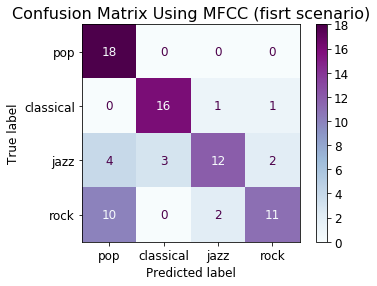

<Figure size 1440x1440 with 0 Axes>



Train accuracy: 81.2%
Test accuracy:  71.2%




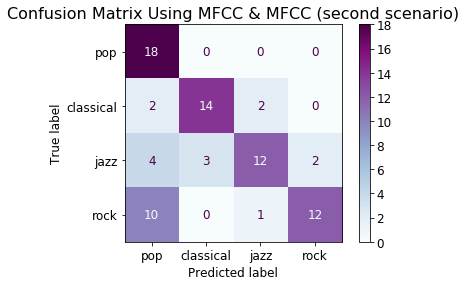

<Figure size 1440x1440 with 0 Axes>

Train accuracy: 93.6%
Test accuracy:  89.3%




In [449]:
# Cenário I
model, train_score1, test_score1 = (
    get_first_scenario_score_and_model(train, test, feature_ex='mfcc', 
                                       return_model=True, degree=2)
)

plt.rcParams.update({'font.size': 12})
disp = plot_confusion_matrix(model, test['mfcc'].to_list(), 
                             test['y'].to_list(), labels=[0,1,2,3],
                             display_labels=['pop', 'classical', 'jazz', 'rock'],
                             cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC (fisrt scenario)', fontsize=16)
plt.figure(figsize=(20,20))
plt.show()

print('\n')
print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score1))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score1))
print('\n')

# Cenário II
model1, model2, model3, train_score2, test_score2 = (
    get_second_scenario_score_and_models(train, test, feature_ex_svm1='mfcc',
                                         feature_ex_svm23='mfcc', degree=2)
)

predictions = (
    second_scenario_predict_an_audio(test['mfcc'].to_list(), 
                                     test['mfcc'].to_list(), 
                                     model1, model2, model3)
)
predictions = [x[0] for x in predictions]

plt.rcParams.update({'font.size': 12})

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test['y'].to_list(), predictions),
                              display_labels=['pop', 'classical', 'jazz', 'rock'])
disp = disp.plot(include_values=True,
                 cmap=plt.cm.BuPu)
disp.ax_.set_title('Confusion Matrix Using MFCC & MFCC (second scenario)', fontsize=16)

plt.figure(figsize=(20,20))
plt.show()

print('\033[1m' + 'Train accuracy:' + '\033[0;0m' + ' {:.1%}'.format(train_score2))
print('\033[1m' + 'Test accuracy: '+ '\033[0;0m' + ' {:.1%}'.format(test_score2))
print('\n')

Nota-se que, ao utilizar a separação inicial dos 4 estilos musicais em 2 grupos (cenário 2) a eficácia do modelo melhorou. Isso nos mostra que, tendo as mesmas ferramentas, podemos melhorar nosso modelo se conhecermos mais sobre o dataset utilizado - nesse caso, ao conhecer um pouco sobre teoria da música, percebemos que seria mais fácil separar, por exemplo, o estilo popular do estilo clássico do que o estilo jazz do estilo classico.

# 8 - Rede neural convolucional

## Adaptando o dataset

In [432]:
train_cnn = train[['x', 'y']]
test_cnn = test[['x', 'y']]

In [504]:
# Train
mfcc_list_train = []

for x in train_cnn['x']:
    mfcc = np.array(librosa.feature.mfcc(y=x, sr=sr))
    zeros = np.zeros((20, (1314 - mfcc.shape[1])))
    mfcc_list_train.append(np.concatenate((mfcc, zeros), axis=1))

train_cnn['mfcc'] = mfcc_list_train

# Test
mfcc_list_test = []

for x in test_cnn['x']:
    mfcc = np.array(librosa.feature.mfcc(y=x, sr=sr))
    zeros = np.zeros((20, (1314 - mfcc.shape[1])))
    mfcc_list_test.append(np.concatenate((mfcc, zeros), axis=1))

test_cnn['mfcc'] = mfcc_list_test


# Results
train_cnn.head()
test_cnn.head()

x  y  \
6   [0.02633667, 0.04815674, 0.05267334, 0.0505981...  1   
20  [0.05722046, 0.06097412, 0.06286621, 0.0684204...  0   
27  [0.011779785, 0.013977051, 0.018920898, 0.0224...  2   
28  [0.0049743652, -0.0015258789, -0.009124756, -0...  3   
31  [-0.0010986328, -0.0010375977, -0.0010986328, ...  1   

                                                 mfcc  
6   [[-197.08810424804688, -201.64662170410156, -2...  
20  [[-283.2794189453125, -298.8136901855469, -313...  
27  [[-337.1222229003906, -347.89703369140625, -36...  
28  [[-141.84959411621094, -47.134639739990234, 0....  
31  [[-582.65234375, -580.6976928710938, -577.4574...

In [511]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(20, 1314, 1)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(4, activation='softmax'))
    return model

In [512]:
model = get_model()

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 19, 1313, 32)      160       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 1312, 48)      6192      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 17, 1311, 120)     23160     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 655, 120)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8, 655, 120)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 628800)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

In [513]:
optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [514]:
import tensorflow as tf

In [515]:
x = [tf.convert_to_tensor([k]) for k in train_cnn['mfcc']]
y = [tf.convert_to_tensor([k]) for k in train_cnn['y']]

In [516]:
x = [tf.reshape(k, [20,1314,1]) for k in x]

In [518]:
y[0].shape

TensorShape([1])

In [517]:
model.fit(x,y)

ValueError: Data cardinality is ambiguous:
  x sizes: 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20
  y sizes: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
Please provide data which shares the same first dimension.